We consider solving Poisson's equation in a square domain with homogeneous Dirichlet boundary conditions
\begin{equation}
    \nabla^2 u = f \quad \text{in} \quad 0 < x < 1, \quad 0 < y < 1
\end{equation}
with
\begin{equation}
    u = 0 \quad \text{on} \quad x = 0\text{, } x = 1\text{, } y = 0\text{, } y = 1.
\end{equation}
A numerical solution is attempted by finding values for $u$ at grid points in a square $N \times N$ mesh.The $(i, j)$-th point is given by $(x_i, y_j ) = (ih, jh)$ where $h = 1/(N - 1)$. The value of $\nabla^2 u$ is approximated at each of the interior points by a finite-difference formula
\begin{equation}
    (\nabla^2 u)_{i,j} \simeq \frac{1}{h^2}[u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j}].
\end{equation}
By requiring that $(\nabla^2 u)_{i,j}$ is equal to $f(x_i, y_j)$ at each of the interior points, we obtain $(N-2)^2$ linear equations for $(N-2)^2$ unknowns $u_{i,j}$, for $1 \leq i,j \leq N-2$ of the form
\begin{equation}
    \frac{1}{h^2}[u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j}] = f(x_i, y_j).
\end{equation}
The values of $u_{i,j}$ at the boundary points are set by the boundary conditions, that is zero.

Typical methods in linear algebra would be quite slow for large $N$, both in terms of time complexity and space complexity. Instead, we use a relaxation method. Reorder the equation to the following iteration scheme, known as the Gauss-Seidel scheme
\begin{equation}
    u_{i,j}^{n+1} = \frac{1}{4}\left[ u_{i-1,j}^{n+1} + u_{i,j-1}^{n+1} + u_{i+1,j}^n + u_{i,j+1}^n - h^2f(x_i, y_j) \right] \quad \text{for} \quad i,j = 1, \dots, N-2,
\end{equation}
where the superscripts denote the number of the iteration.

We define the variation over the grid of the residual error $\epsilon_{i,j}^n$ as
\begin{equation}
    \epsilon_{i,j}^n = \frac{1}{h^2} [u_{i+1,j}^n + u_{i-1,j}^n + u_{i,j+1}^n + u_{i,j-1}^n - 4u_{i,j}^n] - f(x_i, y_j),
\end{equation}
and an approximation for the asymptotic rate of convergence as
\begin{equation}
    r_{\infty} = -\log\left( \lim_{n \to \infty} \left\{ \frac{\max_{i,j} |\epsilon_{i,j}^{n+1}|}{\max_{i,j} |\epsilon_{i,j}^n|} \right\} \right).
\end{equation}

Let $\epsilon(n) = \max_{i,j}|\epsilon_{i,j}^n|$. This represents the maximum error across the grid at iteration $n$. The ratio $\rho = \epsilon(n+1)/\epsilon(n)$ measures the factor by which the maximum error is reduced from one iteration to the next. For the method to converge, the error must decrease which means that $\rho < 1$. A smaller value of $\rho$ indicates a more significant error reduction at each step, hence faster convergence.

Taking the limit $n \to \infty$ captures the asymptotic behaviour since iterative methods may have an initial phase where the error is eratic. The asymptotic error rate focuses on the stable rate of convergence for many iterations and determines the number of steps required to achieve high accuracy. Taking the negative logarithm creates an intuitive scale where a larger $r_{\infty}$ means faster convergence. If this logarithm is in base $10$, then this can be interpreted as the number of digits of accuracy.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def solve_poisson_gauss_seidel(N, tolerance=1e-6, max_iterations=10000):
    '''
    Solves del^2 u = f on a unit square using Gauss-Seidel.
    '''
    # Setup Grid
    h = 1.0 / (N - 1)
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)

    # Source Function f(x,y) = x(1 - X) * Y**2 * (1 - Y)
    f = X * (1 - X) * Y**2 * (1 - Y)

    # Initialise u with zeros (Boundary conditions u = 0 are implicitly set)
    u = np.zeros((N, N))

    # Lists to store metrics
    residuals = []
    convergence_rates = []

    for iteration in range(max_iterations):
        u_old = u.copy()

        # Gauss-Seidel update
        current_max_residual = 0.0

        for i in range(1, N-1):
            for j in range(1, N-1):
                # Standard 5-point stencil update
                # u[i-1, j] and u[i, j-1] are already updated (n+1)
                # u[i+1, j] and u[i, j+1] are from previous step (n)

                u_new_val = 0.25 * (u[i-1, j] + u[i, j-1] +
                                    u[i+1, j] + u[i, j+1] -
                                    h**2 * f[i, j])
                u[i, j] = u_new_val

        # Calculate residual error
        res_grid = np.zeros((N, N))
        for i in range(1, N-1):
            for j in range(1, N-1):
                res_grid[i, j] = (1/h**2) * (u[i+1, j] + u[i-1, j] +
                                             u[i, j+1] + u[i, j-1] -
                                             4*u[i, j]) - f[i, j]

        max_res = np.max(np.abs(res_grid))
        residuals.append(max_res)

        # Calculate asymptotic rate
        if iteration > 0:
            # Avoid division by zero
            if residuals[-2] > 0:
                ratio = residuals[-1] / residuals[-2]
                r_inf = -np.log(ratio)
                convergence_rates.append(r_inf)

        # Check convergence
        if max_res < tolerance:
            print(f"Converged at iteration {iteration} with max residual {max_res:.4e}")
            break

    return u, residuals, convergence_rates

In [ ]:
N_values = [9, 17, 33, 65]
results = {}

for N in N_values:
    print(f"Results for N = {N}")
    u, res, rates = solve_poisson_gauss_seidel(N, tolerance=1e-8, max_iterations=2000)
    results[N] = (u, res, rates)
print("\nEstimated Asymptotic Rates")
for N in N_values:
    if len(results[N][2]) > 0:
        print(f"N={N}: {results[N][2][-1]:.6f}")

Results for N = 9
Converged at iteration 96 with max residual 8.8010e-09
Results for N = 17
Converged at iteration 388 with max residual 9.8663e-09
Results for N = 33
Converged at iteration 1557 with max residual 9.9837e-09
Results for N = 65

Estimated Asymptotic Rates
N=9: 0.158347
N=17: 0.038803
N=33: 0.009654
N=65: 0.002410


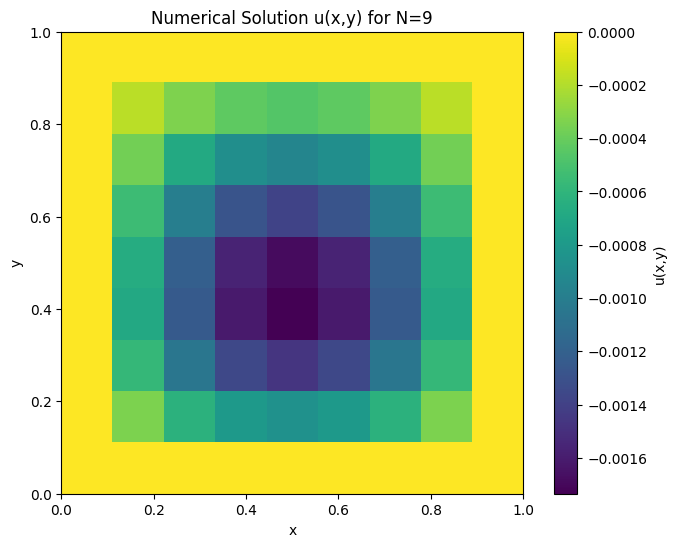

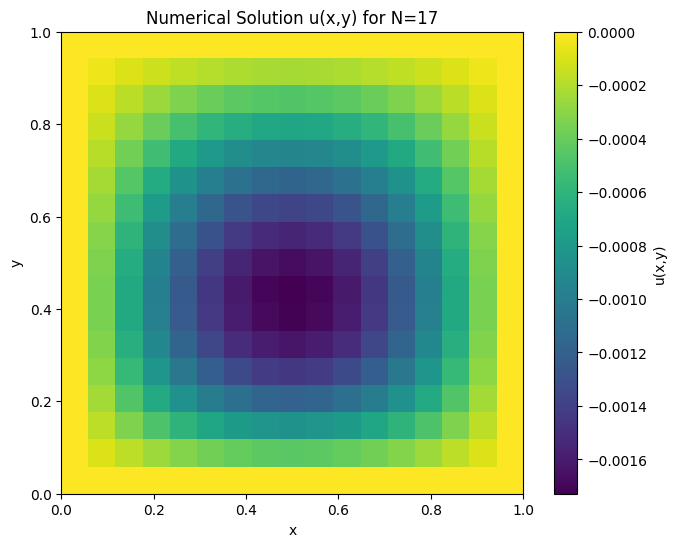

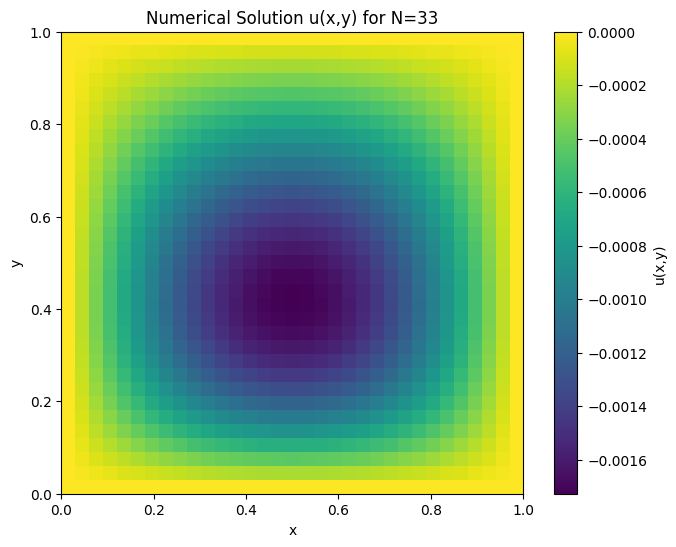

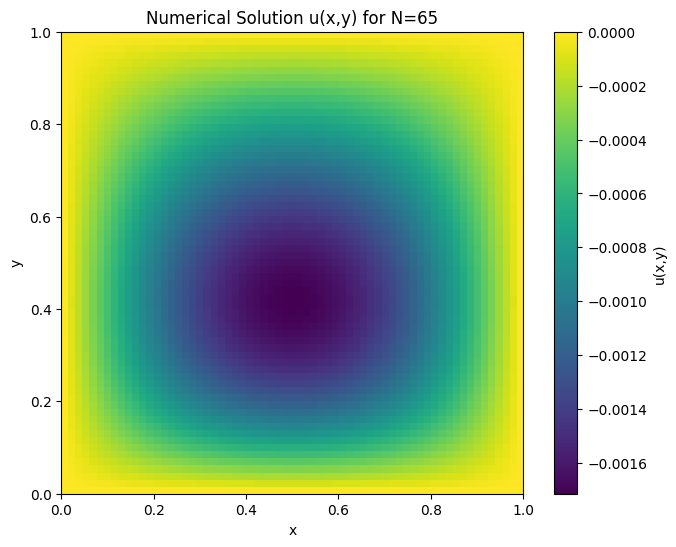

In [20]:
for N in N_values:
    u_solution, _, _ = results[N]
    plt.figure(figsize=(8, 6))
    plt.imshow(u_solution, extent=[0, 1, 0, 1])
    plt.colorbar(label='u(x,y)')
    plt.title(f'Numerical Solution u(x,y) for N={N}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

The iterative method can be viewed in terms of error reduction. If $e^{(n)}$ is the error vector at iteration $n$, then the method generally behaves linearly such that $e^{(n+1)} \approx G e^{(n)}$, where $G$ is the iteration matrix.
For large $n$, the error is dominated by the eigenvector corresponding to the largest eigenvalue (spectral radius $\rho(G)$) of the matrix. Thus, the error decays as:
\begin{equation}
    \|\epsilon^{(n+1)}\| \approx \rho(G) \|\epsilon^{(n)}\|.
\end{equation}
Taking the ratio gives $\rho(G)$, and taking the negative logarithm gives
\begin{equation}
    r_{\infty} = -\log(\rho(G)).
\end{equation}
This is a good definition because it provides a constant, iteration independent value that describes the exponential decay of the error. A higher $r_{\infty}$ means fewer iterations are needed.

To reduce the initial error by a factor of $10^{-k}$, we need $\rho^m \approx 10^{-k}$. Using the approximation $\log \rho \approx \rho - 1$ for $\rho$ close to $1$, we have $m \approx -k \log 10/\log \rho \approx C/r_\infty$. For the Gauss-Seidel method on a Poisson problem, the spectral radius is approximately $\rho \approx 1 - \pi^2 h^2$. Since $h \approx 1/N$, we have $\rho \approx 1 - \pi^2/N^2$, therefore, $r_\infty \approx \pi^2 / N^2$. Substituting this into the iteration count formula yields
\begin{equation}
    m \propto \frac{1}{r_\infty} \propto N^2.
\end{equation}
We conclude that the number of iterations needed for a fixed accuracy scales as $N^2$.

The number of operations required is the number of operations per iteration multiplied by the number of iterations. This is $O(N^2) \times O(N^2) = O(N^4)$ as each iteration, we iterate through the entire grid.

However, the finite difference approximation has a truncation error of order $O(h^2) = O(N^{-2})$, so there is no need for so many iterations. This means that for the required tolerance $\epsilon \propto N^{-2}$, assuming the initial error is $O(1)$, the decay formula $\rho^m \approx N^{-2}$ shows that
\begin{equation}
    m \log \rho \approx \log(N^{-2}) \implies m \approx \frac{2}{C} N^2 \log N.
\end{equation}
Thus the total operations estimate until truncation is $O(N^2) \times O(N^2 \ln N) = O(N^4 \log N)$.